# Kaplan-Meier Plot of PDAC with CPTAC protein expression

## Step 1: Import Data and Dependencies

In [1]:
import pandas as pd
import cptac
import cptac.utils as ut
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import lifelines
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
%matplotlib inline

In [4]:
cptac.download("pdac")

True

In [5]:
pdac = cptac.Pdac()
clinical = pdac.get_clinical()
proteomics = pdac.get_proteomics()
# follow_up = pdac.get_followup()

## Step 2: Gather Data from CPTAC API

In [20]:
cols = list(clinical.columns)
omics_genes = ['ADO', 'CSAD', 'LRRC8A', 'LRRC8C', 'LRRC8D', 'PHGDH', 'SLC6A6', 'SLC36A1', 'STAT5A', 'STAT5B', 'GGT1', 'GAD2']

clinical_and_protein = pdac.join_metadata_to_omics(metadata_df_name="clinical", 
                                                 omics_df_name="proteomics", 
                                                 metadata_cols=cols, 
                                                 omics_genes=omics_genes,
                                                 quiet=True)

# clinical_and_protein = ut.reduce_multiindex(clinical_and_protein, 
#                                             levels_to_drop="Database_ID")

Next, we will rename the foreign key ("PPID" -> "Patient_ID") on the follow_up table to allow us to easily join that data with the dataframe of clinical and protein data

In [29]:
#Determine columns to focus on, and create a subset to work with
columns_to_focus_on = ['follow_up_days',
                       'vital_status',
                      'tumor_stage_pathological']

#This adds the protein data that we got from the clinical and proteomics join
#so that it will be present in our subset of data to work with
for i in range(len(omics_genes)):
    if not omics_genes[i].endswith('_proteomics'):
        omics_genes[i] += '_proteomics'
        
    columns_to_focus_on.append(omics_genes[i])

focus_group = clinical_and_protein[columns_to_focus_on].copy().drop_duplicates()
focus_group = focus_group[~np.isnan(focus_group['follow_up_days'])]

## Step 3: Kaplan Meier Plotting
Kaplan Meier plots show us the probability of some event occuring over a given length of time, based on some attribute(s).  Oftentimes, they are used to plot the probability of death for clinical attributes, however they could also be used in a variety of other contexts. 

We will start by finding all patients that have died during the follow-up period and update the column to contain boolean values, where True denotes that the event occurred ('Deceased'), and False denotes that it did not ('Living').  We will then combine the two columns containing timeframe data ('Days_Between_Collection_And_Last_Contact', and 'Days_Between_Collection_And_Death'), to help us with plotting survival curves. These steps are necessary to fit the requirements of the *lifelines* package.

In [30]:
#Make the Vital Status column boolean
focus_group['vital_status'] = focus_group['vital_status'].replace('Living', False)
focus_group['vital_status'] = focus_group['vital_status'].replace('Deceased', True)
focus_group['vital_status'] = focus_group['vital_status'].astype('bool')

Next, we will create a general Kaplan Meier Plot of overall survival for our cohort, using the KaplanMeierFitter() from the *lifelines* package.

<AxesSubplot:xlabel='timeline'>

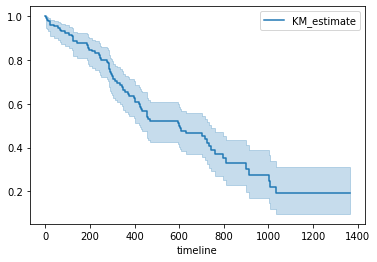

In [31]:
time = focus_group['follow_up_days']
status = focus_group['vital_status']

kmf = KaplanMeierFitter()
kmf.fit(time, event_observed = status)
kmf.plot()

# Step 4 Prepare Data for Multivariate Kaplan Meier Plots and Cox's Proportional Hazard Test
We will now group our columns of interest into 3-4 distinct categories each, and assign them numeric values.  It is necessary for the requirements of the *lifelines* package that the categories are assigned numeric values (other data types, including category, are not compatible with the functions we will be using).

In [32]:
df_genes = focus_group.copy()

#Here, we are separating the protein abundance values for each of our proteins
#of interest into 3 groups, based on relative abundance of the protein
for col in omics_genes:
    lower_25_filter = df_genes[col] <= df_genes[col].quantile(.25)
    upper_25_filter = df_genes[col] >= df_genes[col].quantile(.75)

    df_genes[col] = np.where(lower_25_filter, "Lower_25%", df_genes[col])
    df_genes[col] = np.where(upper_25_filter, "Upper_25%", df_genes[col])
    df_genes[col] = np.where(~lower_25_filter & ~upper_25_filter, "Middle_50%", df_genes[col])

In [33]:
#Here, we map numeric values to correspond with our 3 protein categories
proteomics_map = {"Lower_25%" : 1, "Middle_50%" : 2, "Upper_25%" : 3}
for gene in omics_genes:
    df_genes[gene] = df_genes[gene].map(proteomics_map)

In [35]:
#Here we map numeric values to corresponding tumor stages
stage_map = {"Stage IA" : 1, "Stage IB" : 1,
             "Stage IIA": 2, "Stage IIB" : 2,
             "Stage III": 3,
             "Stage IV": 4, 
             "NA" : np.nan}

df_genes['tumor_stage_pathological'] = df_genes['tumor_stage_pathological'].map(stage_map)

In [36]:
#Then we will drop missing values, as missing values 
# will throw an error in the lifelines functions
df_clean = df_genes.dropna(axis=0, how='any').copy()

Verify that your columns are the correct data types.  They may appear to be correct up front, but could actually be hidden as slightly different data types. The event of interest, in this case *vital_status* needs to contain boolean values, and all other columns in the table must be of a numeric type (either int64 or float64).

In [37]:
for col in df_clean.columns:
    print(col, ":", df_clean[col].dtype)

follow_up_days : float64
vital_status : bool
tumor_stage_pathological : float64
ADO_proteomics : int64
CSAD_proteomics : int64
LRRC8A_proteomics : int64
LRRC8C_proteomics : int64
LRRC8D_proteomics : int64
PHGDH_proteomics : int64
SLC6A6_proteomics : int64
SLC36A1_proteomics : int64
STAT5A_proteomics : int64
STAT5B_proteomics : int64
GGT1_proteomics : int64
GAD2_proteomics : int64


In [38]:
df_clean.head()

Name,follow_up_days,vital_status,tumor_stage_pathological,ADO_proteomics,CSAD_proteomics,LRRC8A_proteomics,LRRC8C_proteomics,LRRC8D_proteomics,PHGDH_proteomics,SLC6A6_proteomics,SLC36A1_proteomics,STAT5A_proteomics,STAT5B_proteomics,GGT1_proteomics,GAD2_proteomics
Patient_ID,,,,,,,,,,,,,,,
C3L-00017,426.0,False,2.0,2,2,2,1,1,1,2,1,2,1,3,2
C3L-00102,249.0,True,3.0,2,3,2,3,2,1,2,2,2,3,3,2
C3L-00189,1035.0,True,2.0,2,2,2,2,2,1,2,2,2,2,2,2
C3L-00277,610.0,True,2.0,3,2,2,2,2,3,2,2,2,1,1,3
C3L-00401,1228.0,False,2.0,2,2,1,3,2,2,2,2,3,2,1,2


# Step 5: Multivariate Survival Risk Plotting

With the CoxPHFitter from the lifelines package we can create covariate survival plots, as shown below.  The variables we are interested in exploring are Tumor Stage, RAC2 abundance, and PODXL  abundance.

First we will fit our model to the data we have prepared using the CoxPHFitter() class from the lifelines module.

In [39]:
cph = CoxPHFitter()
cph.fit(df_clean, duration_col = "follow_up_days", 
        event_col = "vital_status")

<lifelines.CoxPHFitter: fitted with 131 total observations, 57 right-censored observations>

Then we will plot each of the attributes to see how different levels of protein or different tumor stages affect survival outcomes in Ovarian Cancer patients.

In [40]:
attributes = ['tumor_stage_pathological', 'ADO_proteomics', 'CSAD_proteomics', 'GGT1_proteomics']

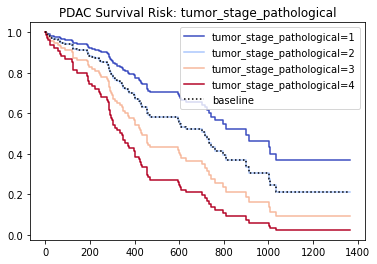

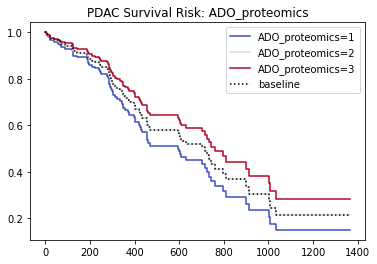

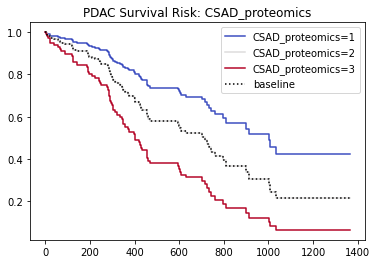

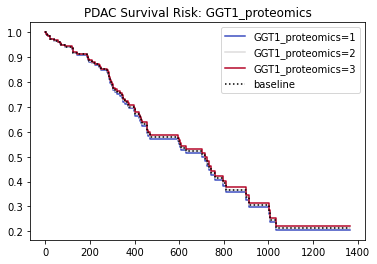

In [44]:
for attribute in attributes:
    if attribute == 'tumor_stage_pathological':
        num_cat = 4
    else:
        num_cat = 3
    plot_title = "PDAC Survival Risk: " + attribute
    cph.plot_partial_effects_on_outcome(attribute, range(1,num_cat+1), cmap='coolwarm', 
                          title=plot_title)

# Results
These different analyses tend to follow the baseline survival function, however, there are some differences in varying levels of each attribute. For example, FIGO Stage I tumors tend to have a higher survival rate over time comparatively to Stage III tumors.  We can explore these differences with the CoxPHFitter object's *print_summary* function (which prints out results for multivariate linear regression).

In [45]:
cph.print_summary(model="untransformed variables", decimals=3)

/Users/hoonsik/opt/anaconda3/envs/cptac-final/lib/python3.8/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 131 total observations, 57 right-censored observations>
             duration col = 'follow_up_days'
                event col = 'vital_status'
      baseline estimation = breslow
   number of observations = 131
number of events observed = 74
   partial log-likelihood = -296.428
         time fit was run = 2022-07-31 16:32:25 UTC
                    model = untransformed variables

---
                           coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                        
tumor_stage_pathological  0.434      1.544      0.166            0.108            0.761                1.114                2.140
ADO_proteomics           -0.206      0.814      0.180           -0.559            0.148                0.572                1.159
CSAD_proteomics           0.580      1.786      0.383           -0.171            1.331                0.843                3.784
LRRC8A_proteomics         0.129      1.137      0.185           -0.233            0.491                0.792                1.634
LRRC8C_proteomics        -0.445      0.641      0.244           -0.924            0.034                0.397                1.035
LRRC8D_proteomics         0.123      1.130      0.283           -0.433            0.678                0.649                1.970
PHGDH_proteomics          0.200      1.222      0.170           -0.134            0.534                0.875                1.706
SLC6A6_proteomics        -0.452      0.636      0.389           -1.215            0.311                0.297                1.365
SLC36A1_proteomics        0.649      1.914      0.381           -0.098            1.396                0.907                4.040
STAT5A_proteomics        -0.051      0.951      0.183           -0.410            0.309                0.664                1.362
STAT5B_proteomics        -0.240      0.787      0.200           -0.632            0.152                0.532                1.164
GGT1_proteomics          -0.024      0.976      0.191           -0.398            0.350                0.671                1.418
GAD2_proteomics           0.034      1.034      0.244           -0.445            0.513                0.641                1.669

                           cmp to      z     p   -log2(p)
covariate                                                
tumor_stage_pathological    0.000  2.611 0.009      6.789
ADO_proteomics              0.000 -1.140 0.254      1.976
CSAD_proteomics             0.000  1.514 0.130      2.944
LRRC8A_proteomics           0.000  0.697 0.486      1.041
LRRC8C_proteomics           0.000 -1.821 0.069      3.866
LRRC8D_proteomics           0.000  0.433 0.665      0.588
PHGDH_proteomics            0.000  1.176 0.240      2.061
SLC6A6_proteomics           0.000 -1.161 0.246      2.025
SLC36A1_proteomics          0.000  1.703 0.089      3.496
STAT5A_proteomics           0.000 -0.276 0.783      0.353
STAT5B_proteomics           0.000 -1.199 0.231      2.116
GGT1_proteomics             0.000 -0.128 0.898      0.155
GAD2_proteomics             0.000  0.138 0.890      0.168
---
Concordance = 0.653
Partial AIC = 618.855
log-likelihood ratio test = 23.652 on 13 df
-log2(p) of ll-ratio test = 4.858

# Step 6 Cox's Proportional Hazard Test
With the *proportional_hazard_test* function, we can now perform Cox's Proportional Hazard Test on the data to determine how each attribute contributes to our cohort's overall survival.  This is shown by the hazard ratio in the column labeled *-log2(p)* below.  In general, a hazard ratio of 1 suggests that an attribute has no effect on overall survival.  A ratio less than 1 suggests that an attribute contributes to lower survival risk.  A ratio greater than 1 suggests that an attribute contributes to higher survival risk.

In [46]:
results = proportional_hazard_test(cph, df_clean, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

/Users/hoonsik/opt/anaconda3/envs/cptac-final/lib/python3.8/site-packages/lifelines/statistics.py:143: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return self.summary.to_latex()


<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 131 total observations, 57 right-censored observations>
         test_name = proportional_hazard_test

---
                          test_statistic    p  -log2(p)
ADO_proteomics                      0.03 0.86      0.22
CSAD_proteomics                     0.01 0.93      0.10
GAD2_proteomics                     1.39 0.24      2.07
GGT1_proteomics                     0.19 0.67      0.59
LRRC8A_proteomics                   0.00 0.96      0.06
LRRC8C_proteomics                   0.01 0.91      0.13
LRRC8D_proteomics                   5.67 0.02      5.86
PHGDH_proteomics                    0.06 0.80      0.32
SLC36A1_proteomics                  0.01 0.92      0.12
SLC6A6_proteomics                   0.39 0.53      0.91
STAT5A_proteomics                   1.63 0.20      2.31
STAT5B_proteomics                   0.34 0.56      0.83
tumor_stage_pathological            0.96 0.33      1.61

Below, we show confidence intervals for each of the hazard ratios.  Since both bars include the log(HR) of 1.0 and both of their p-values were greater than 0.05, there is insufficient evidence to suggest that a specific Histologic Grade or Tumor Stage is connected with negative clinical outcomes of death or the development of a new tumor *in our cohort of Ovarian cancer tumors*.

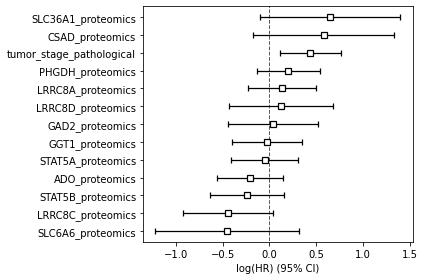

In [47]:
cph.plot()
plt.tight_layout()

# Closing Remarks
It is important to note that there are relatively few patients who died in our cohort (7 out of 88), which is good, but with such a small sample size of death events, it is difficult to conclude with certainty that these features are not more or less connected with survival.  Perhaps a sample of patients with more deaths might have different results.  Alternatively, studying an event with more negative outcomes (such as tumor recurrence) may also provide more data to work with.

In [48]:
df_clean['vital_status'].value_counts()

True     74
False    57
Name: vital_status, dtype: int64

It is also important to note that the confidence intervals for these ratios are very large, especially since hazard ratios are standardly shown on a log-scale.

In [49]:
cph.confidence_intervals_

,95% lower-bound,95% upper-bound
covariate,,
tumor_stage_pathological,0.108261,0.760604
ADO_proteomics,-0.559122,0.147799
CSAD_proteomics,-0.170637,1.330847
LRRC8A_proteomics,-0.233416,0.491018
LRRC8C_proteomics,-0.924153,0.033955
LRRC8D_proteomics,-0.432662,0.677901
PHGDH_proteomics,-0.133507,0.534080
SLC6A6_proteomics,-1.215006,0.311178
SLC36A1_proteomics,-0.098151,1.396242


This is just one example of how you might use Survival Analysis to learn more about different types of cancer, and how clinical and/or genetic attributes contribute to likelihood of survival. There are many other clinical and genetic attributes, as well as several other cancer types, that can be explored using a similar process to that above. In particular, lung cancer and ovarian cancer have a larger number of negative outcomes per cohort, and would be good to look into further. 